In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns

from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis import DriftingGratings

%load_ext autoreload
%autoreload 2

In [2]:
# windows
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"

# # linux and mac
# base_folder = "/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
base_folder = "/Users/chase/Desktop/test_v1dd_data"
# base_folder = "/Volumes/AllenDrive/v1dd/data" # Chase's external hard drive
client = OPhysClient(base_folder)

In [3]:
mouse = 409828
col, vol = 1, 3
sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)
# Alternatively
# sess = client.load_ophys_session(session_id="M409828_13")
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [4]:
plane = sess.get_planes()[0]
print(f"Analyzing plane {plane}")

Analyzing plane 1


Number of times diff > 0.18: 6


Text(0.5, 1.0, 'np.diff(trace_timestamps); mean$\\approx 0.1652$ s')

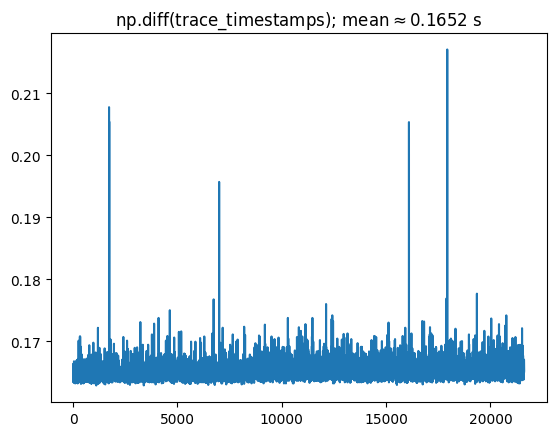

In [5]:
traces = sess.get_traces(plane, trace_type="dff")
frame_dur = np.mean(np.diff(traces.time))
print("Number of times diff > 0.18:", np.count_nonzero(np.diff(traces.time) > 0.18))
plt.plot(np.diff(traces.time))
plt.title(f"np.diff(trace_timestamps); mean$\\approx {frame_dur:.4f}$ s")
# plt.figure()
# plt.plot(timestamps)

In [6]:
spont_table = sess.get_stimulus_table("spontaneous")[0]

In [7]:
dg = DriftingGratings(sess, plane, dg_type="full")

In [8]:
dg.stim_table

,start,end,temporal_frequency,spatial_frequency,direction
0,54.634430,56.619442,1.0,0.04,30.0
1,57.636951,59.622009,1.0,0.08,300.0
2,60.639420,62.624439,1.0,0.04,300.0
3,63.641949,65.626930,1.0,0.08,300.0
4,66.644447,68.629433,1.0,0.04,330.0
...,...,...,...,...,...
187,2978.068604,2980.053711,1.0,0.04,60.0
188,2981.071289,2983.056152,1.0,0.08,150.0
189,2984.073730,2986.058594,1.0,0.08,0.0
190,2987.076172,2989.061035,1.0,0.04,240.0


In [9]:
dg.stim_meta

{'temporal_frequency': 1.0,
 'contrast': 0.8,
 'duration': 2,
 'padding': 1.0,
 'num_samples': 192,
 'n_trials': 8,
 'center_position': (0, 0),
 'radius': 90.0}

# Compute response metrics
This computation is relatively expensive, so for many planes it may take a while

In [10]:
dg._metrics = None # force recompute the metrics

# This will speed things up
dg.fit_tuning_curve = False
# dg.n_null_distribution_boot = 100
dg.n_chisq_shuffles = 10

metrics = dg.metrics.loc[dg.metrics.is_valid]
metrics["is_responsive"] = dg.metrics.frac_responsive_trials >= 0.5
metrics.head()

Loading DG-full response metrics for session M409828_13, plane 1...


/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_35920/2742060194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["is_responsive"] = dg.metrics.frac_responsive_trials >= 0.5


,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std,is_responsive
0,0.00119,0,0.04,0,0,344.394353,3.158839,0.0028,0.475473,0.133519,...,False,"[4.109224043350412, 0.0, 1.0973832929047718, 2...",True,0,0.5,0.000426,0.000242,0.000432,0.000687,False
1,0.000967,330,0.08,11,1,186.033921,1.258647,0.1143,0.725392,0.219281,...,False,"[-0.597946596978335, -0.019879136386476776, -0...",True,150,0.9,0.000569,0.000316,0.000574,0.0009,False
2,0.000997,0,0.04,0,0,0.720385,0.075905,0.434,0.304752,0.13728,...,False,"[-0.267518119416553, -0.8351783183638415, -0.6...",True,0,0.2,0.000958,0.000513,0.000954,0.001468,False
3,0.002335,120,0.04,4,0,63.918717,3.221015,0.0049,0.364305,0.288559,...,True,"[1.5996856156245554, 2.306706829546597, 1.1596...",True,120,0.2,0.000788,0.00048,0.000786,0.00136,False
4,0.001463,120,0.04,4,0,226.724078,0.978192,0.1446,0.673527,0.344926,...,False,"[0.9146344490637311, -0.5836494009128873, -0.5...",True,120,0.0,0.000869,0.000607,0.000845,0.001673,False


In [11]:
n_responsive = metrics["is_responsive"].value_counts()[True]
# n_responsive = (dg.metrics["frac_responsive_trials"] >= 0.5).value_counts()[True]
print(f"{n_responsive}/{dg.n_rois_valid} ({n_responsive/dg.n_rois_valid*100:.1f}%) ROIs are responsive to DG-{dg.dg_type}")

58/409 (14.2%) ROIs are responsive to DG-full


In [12]:
metrics[metrics["is_responsive"]].head(10)

,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std,is_responsive
6,0.020628,330,0.08,11,1,338.861023,70.939617,0.0,0.978257,0.751979,...,True,"[15.919955304696964, 0.9469666671584286, -0.24...",True,150,0.4,0.000458,0.000284,0.000455,0.000803,True
10,0.001344,330,0.04,11,0,315.43778,5.438484,0.0,0.642606,0.355247,...,True,"[0.1810080834205535, -0.6402137410376645, -0.0...",True,150,0.0,0.000327,0.000187,0.000328,0.000529,True
14,0.010412,120,0.04,4,0,111.873994,39.161733,0.0,0.840225,0.577535,...,True,"[-0.12416419991167552, 2.426104097317507, 0.49...",True,120,0.0,0.000448,0.000254,0.000445,0.000717,True
26,0.073731,0,0.04,0,0,359.711836,301.388896,0.0,0.984051,0.895999,...,True,"[167.29175759723313, 28.791450057195632, 0.416...",True,0,0.0,0.000397,0.000243,0.000387,0.000676,True
27,0.001594,300,0.04,10,0,351.044261,5.015374,0.0,0.508075,0.274553,...,False,"[0.21553416124731956, 0.12196735815191688, -0....",True,120,0.0,0.000397,0.000239,0.000406,0.000684,True
29,0.014377,120,0.04,4,0,113.42211,42.88836,0.0,0.908926,0.738944,...,True,"[2.4105345855040032, 3.235768057038284, 1.2581...",True,120,0.0,0.000544,0.000323,0.00053,0.000893,True
30,0.008538,180,0.08,6,1,180.458074,30.22403,0.0,0.92253,0.741383,...,True,"[2.971922477293089, 0.7233722095634066, -0.604...",True,0,0.0,0.000418,0.000269,0.000416,0.000765,True
33,0.001083,300,0.04,10,0,300.179997,3.830638,0.0015,0.513415,0.148603,...,False,"[0.1827309260745887, 0.025910122148465147, -0....",True,120,0.8,0.000298,0.000205,0.000301,0.000579,True
39,0.00194,300,0.04,10,0,304.382869,3.463606,0.0069,0.622764,0.200794,...,False,"[1.0133745673426584, 0.00014683394731337677, 0...",True,120,0.2,0.00055,0.000402,0.000525,0.001067,True
41,0.028897,30,0.04,1,0,351.686646,87.475155,0.0,0.981707,0.823294,...,True,"[12.486633071048903, 26.343707643676904, 0.682...",True,30,0.0,0.000521,0.000324,0.000515,0.000928,True


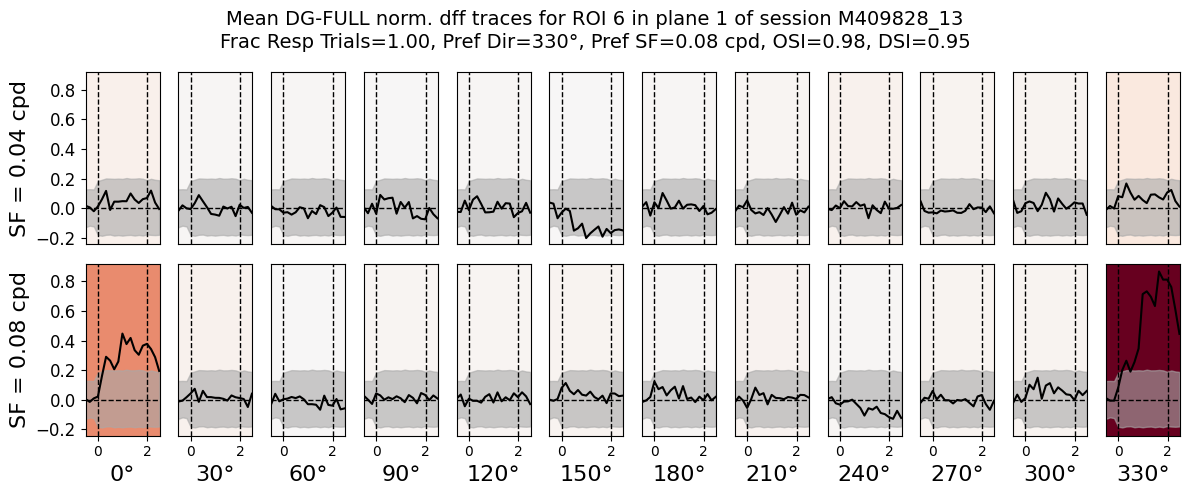

In [13]:
# Plot out traces for a particular roi
roi = 6
fig = dg.plot_roi_stim_conditions(roi, use_baseline_normalized_traces=True)

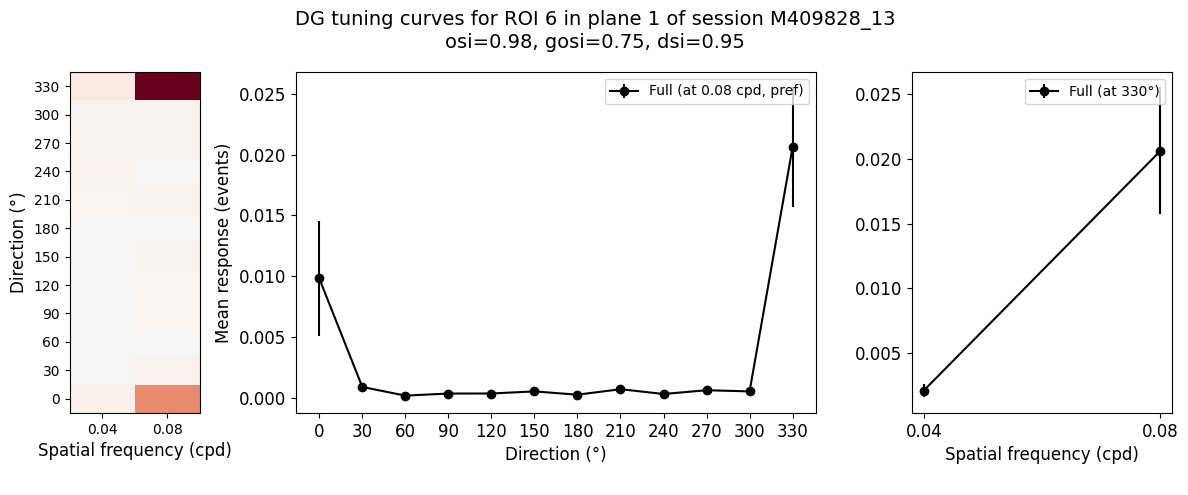

In [14]:
fig = dg.plot_roi_tuning_curves(roi)

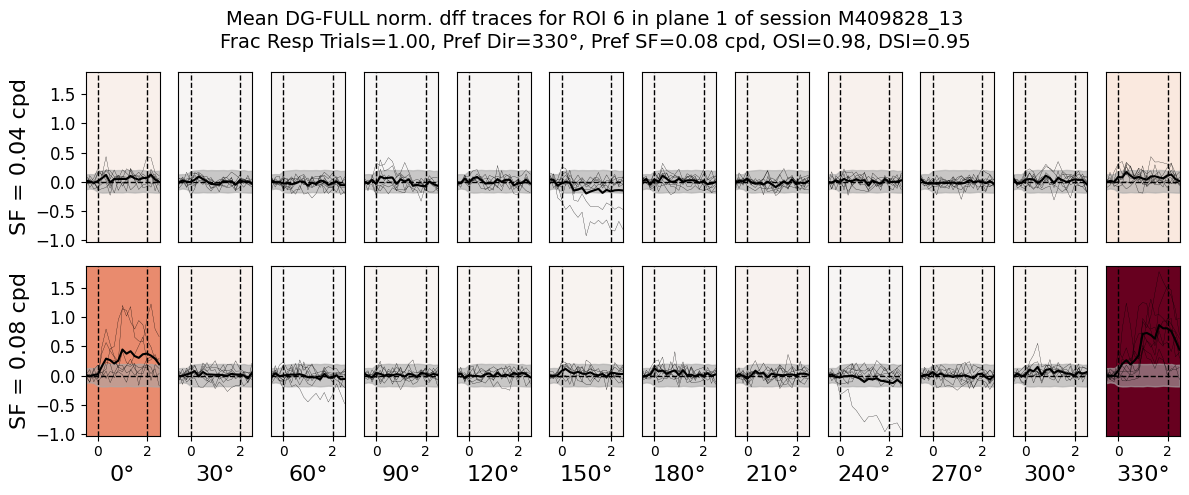

In [15]:
fig = dg.plot_roi_stim_conditions(roi=roi, use_baseline_normalized_traces=True, plot_individual_traces=True)

In [16]:
dg.trial_responses.shape

(1234, 12, 2, 8)

<Axes: title={'center': 'DG-full trial responses for ROI 6 in plane 1 of session M409828_13'}, xlabel='Direction (°)', ylabel='Mean event response to trial'>

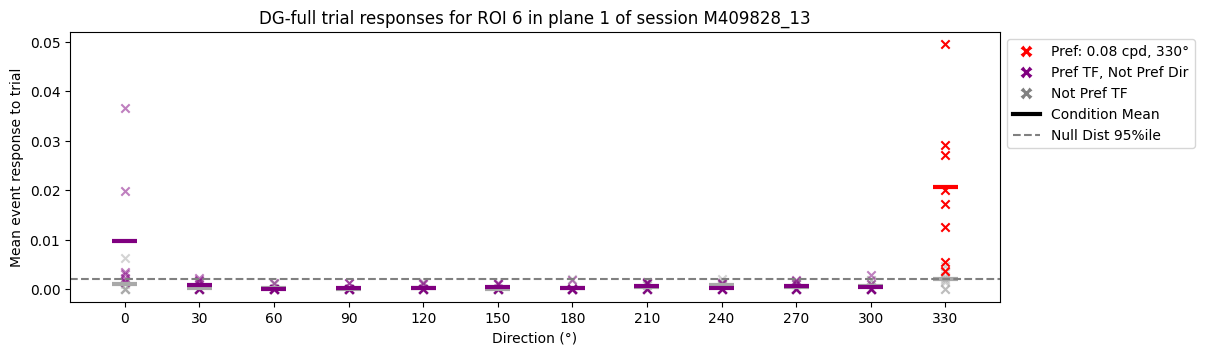

In [17]:
dg.plot_trial_responses(roi)

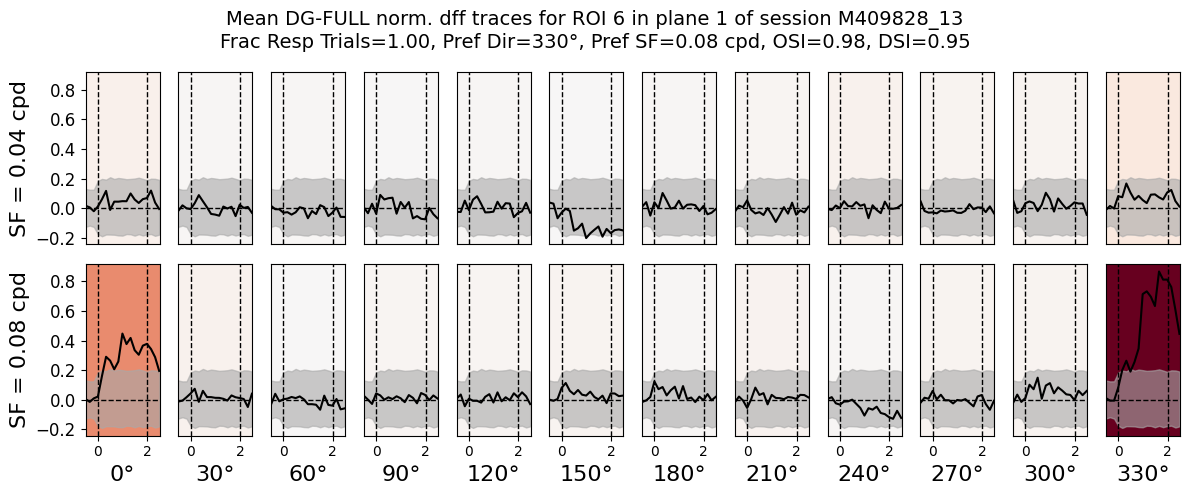

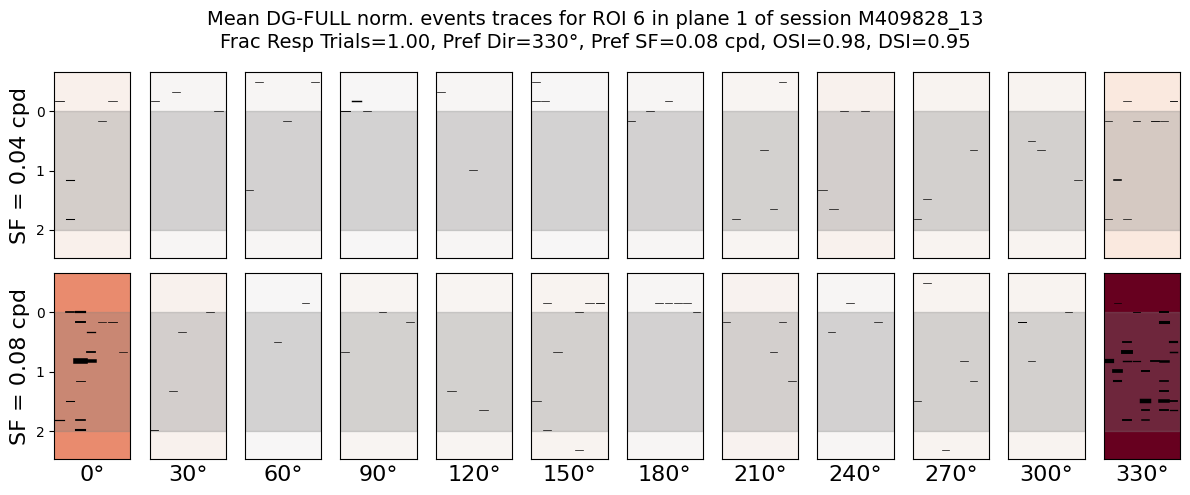

In [18]:
fig = dg.plot_roi_stim_conditions(roi)
fig = dg.plot_roi_stim_conditions(roi, trace_type="events")

## Examine inclusion criteria

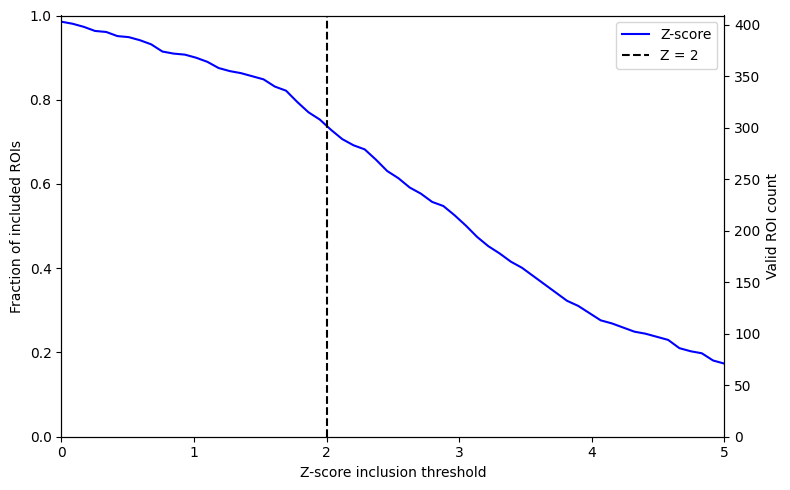

In [19]:
x = np.linspace(0, 5, 60)
y = [np.mean(metrics.z_score >= thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, y, color="b", label="Z-score")
ax.axvline(x=2, color="black", linestyle="dashed", label="Z = 2")
ax.set_xlabel("Z-score inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax2 = ax.twinx()
ax2.set_ylim(0, len(metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()

In [20]:
((metrics.frac_responsive_trials >= 0.25) & (metrics.z_score >= 2)).mean()

0.5770171149144254

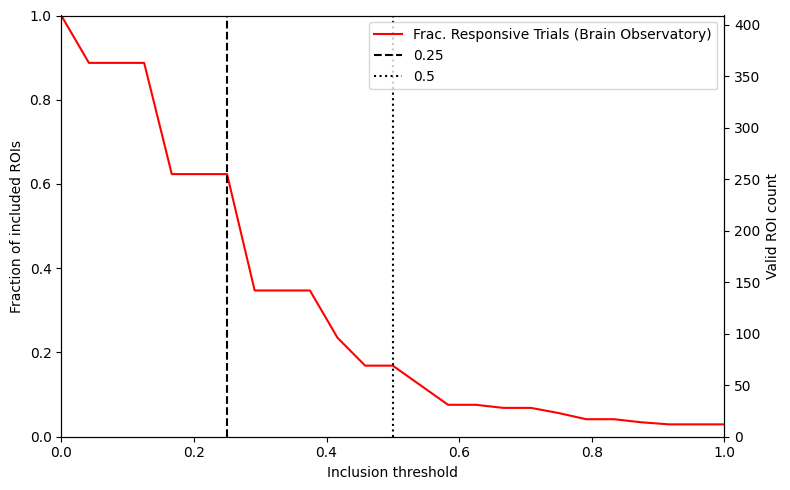

In [21]:
x = np.linspace(0, 1, 25)
y = [np.mean(metrics.frac_responsive_trials >= thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, y, color="r", label="Frac. Responsive Trials (Brain Observatory)")
ax.axvline(x=0.25, color="black", linestyle="dashed", label="0.25")
ax.axvline(x=0.5, color="black", linestyle="dotted", label="0.5")
ax.set_xlabel("Inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax2 = ax.twinx()
ax2.set_ylim(0, len(metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()

## Normalized response plot

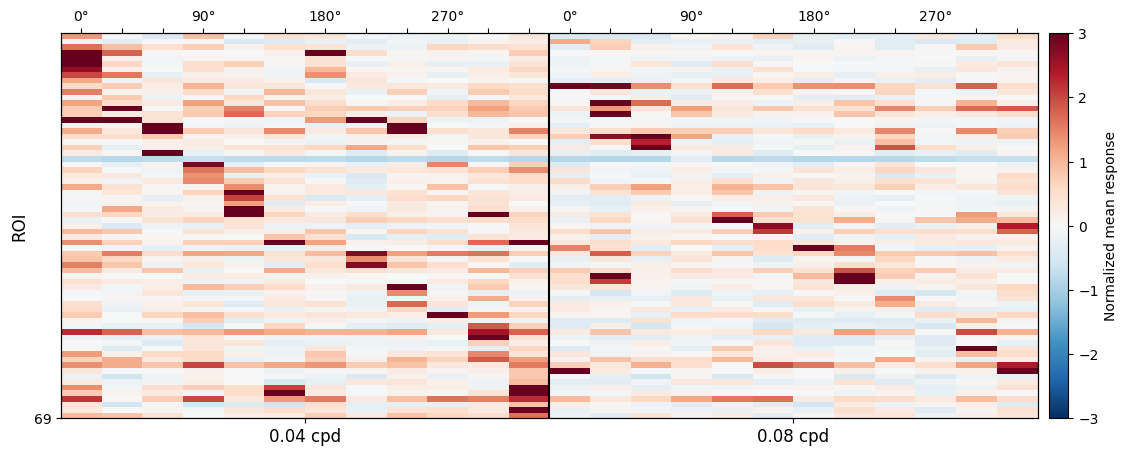

In [22]:
inclusion = metrics.frac_responsive_trials >= 0.5
# inclusion = metrics.chisq_response_p <= 0.01
ax = dg.plot_waterfall_normalized_responses(included_idx=metrics.index[inclusion], center_zero_direction=False)
# ax = dg.plot_waterfall_normalized_responses(included_idx=metrics.index[inclusion], center_zero_direction=True)

## Chi-squared response probabilities

In [101]:
def compute_chisq_statistic(observed, expected):
    chi = np.square(expected - observed) / expected
    chi = np.where(expected > 0, chi, 0)  
    return np.sum(chi, axis=1)

roi = 6

n_conditions = len(dg.dir_list)*len(dg.sf_list)+1

def compute_observed(sweep_events, sweep_category_matrix):
    n_cells = sweep_events.shape[1]
    n_sweeps, n_conditions = sweep_category_matrix.shape

    observed_matrix = sweep_events.T[:, np.newaxis] * sweep_category_matrix[np.newaxis, :]
    return np.sum(observed_matrix, axis=1)
    

# observed = np.zeros((1, n_conditions), dtype=dg.trial_responses.dtype) # (n_cells, n_conditions)
# print(observed.shape)
# mean_trial_responses = np.nanmean(dg.trial_responses, axis=3)

# for dir_i in range(len(dg.dir_list)):
#     for sf_i in range(len(dg.sf_list)):
#         i = len(dg.sf_list)*dir_i + sf_i
#         observed[:, i] = mean_trial_responses[:, dir_i, sf_i][roi]

# Add null response
# observed[:, -1] = dg.blank_responses.mean(axis=1)[roi]

# expected = observed.mean(axis=1) # (n_rois,)

# chisq_actual = compute_chisq_statistic(observed, expected)
# print(chisq_actual, st.distributions.chi2.sf(chisq_actual, 1))

import itertools

# list(set([tuple(condition) for condition in dg.stim_table[["direction", "spatial_frequency"]].values]))
columns = ["direction", "spatial_frequency"]
stim_table_values = dg.stim_table[columns].values
unique_values = [dg.stim_table[c].dropna().sort_values().unique() for c in columns]
sweep_categories = np.zeros(len(dg.stim_table), dtype=int)
sweep_categories[dg.stim_table[columns].isna().any(axis=1)] = 0 # Set nan values to 0
for values in itertools.product(*unique_values):
    mask = np.all(stim_table_values == values, axis=1)
    if np.any(mask):
        sweep_categories[mask] = sweep_categories.max() + 1

n_sweeps = len(dg.stim_table)
categories = np.sort(np.unique(sweep_categories))
n_categories = len(categories)
sweep_category_matrix = np.zeros((n_sweeps, n_categories))

for cat in categories:
    sweep_idx = np.argwhere(sweep_categories == cat)[:, 0]
    sweep_category_matrix[sweep_idx, cat] = True

# Note: Blank sweep are at column 0

n_category_trials = sweep_category_matrix.sum(axis=0)

def compute_observed(sweep_responses):
    mean_category_response = np.dot(sweep_responses.T, sweep_category_matrix) / n_category_trials
    return mean_category_response # (n_cells, n_conditions)
    # each entry (i, j) = (cell i's mean observed response to category j)

def compute_expected(sweep_responses):
    # return np.outer(np.mean(sweep_responses, axis=0), n_category_trials)
    n_cells = sweep_responses.shape[1]
    return np.mean(sweep_responses, axis=0).reshape(n_cells, 1)

def compute_observed_dan(mean_sweep_events,sweep_conditions):
    (num_sweeps,num_conditions) = np.shape(sweep_conditions)
    num_cells = np.shape(mean_sweep_events)[1]   
    
    observed_mat = (mean_sweep_events.T).reshape(num_cells,num_sweeps,1) * sweep_conditions.reshape(1,num_sweeps,num_conditions)
    observed = np.sum(observed_mat,axis=1)
    
    return observed
    
def compute_expected_dan(mean_sweep_events,sweep_conditions):
    # mean_sweep_events.shape = (n_sweeps, n_cells)
    # sweep_conditions.shape = (n_sweeps, n_conditions) (binary)
    num_conditions = np.shape(sweep_conditions)[1]
    num_cells = np.shape(mean_sweep_events)[1]
    
    sweeps_per_condition = np.sum(sweep_conditions,axis=0) # m_i (n_conditions,)
    events_per_sweep = np.mean(mean_sweep_events,axis=0) # sum_{i,j} R_{i,j} / (sum_i m_i) (n_cells,)
    
    expected = sweeps_per_condition.reshape(1,num_conditions) * events_per_sweep.reshape(num_cells,1) 
    # (n_cells, n_conditions)
    # expected[i,j] = (average response of cell i) * (number of times condition j shows up)
    return expected

observed = compute_observed(dg.sweep_responses)
expected = compute_expected(dg.sweep_responses)
chisq_actual = compute_chisq_statistic(observed, expected)
chisq_dan = compute_chisq_statistic(compute_observed_dan(dg.sweep_responses, sweep_category_matrix), compute_expected_dan(dg.sweep_responses, sweep_category_matrix))
# print(chisq_actual[6])
# print(chisq_dan[6])
# print(chisq_actual[6], st.distributions.chi2.sf(chisq_actual[6], 1))

# Shuffle chi-square
n_shuffles = 2000
n_sweeps = len(dg.stim_table)
n_rois = dg.n_rois
chisq_shuffle = np.zeros((n_rois, n_shuffles))

np.random.seed(420)
for shuffle_i in range(n_shuffles):
    shuffle_stim_idx = np.random.choice(n_sweeps, size=n_sweeps, replace=True)
    shuffle_sweep_events = dg.sweep_responses[shuffle_stim_idx] # (n_sweeps, n_rois)

    shuffle_observed = compute_observed(shuffle_sweep_events)
    shuffle_expected = compute_expected(shuffle_sweep_events)
    chisq_shuffle[:, shuffle_i] = compute_chisq_statistic(shuffle_observed, shuffle_expected)
    # chisq_shuffle[:, shuffle_i] = compute_chisq_statistic(compute_observed_dan(shuffle_sweep_events, sweep_category_matrix), compute_expected_dan(shuffle_sweep_events, sweep_category_matrix))

# chisq_shuffle_dan = np.zeros((n_rois, n_shuffles))

# np.random.seed(420)
# for shuffle_i in range(n_shuffles):
#     shuffle_stim_idx = np.random.choice(n_sweeps, size=n_sweeps, replace=True)
#     shuffle_sweep_events = dg.sweep_responses[shuffle_stim_idx] # (n_sweeps, n_rois)

#     chisq_shuffle_dan[:, shuffle_i] = compute_chisq_statistic(compute_observed_dan(shuffle_sweep_events, sweep_category_matrix), compute_expected_dan(shuffle_sweep_events, sweep_category_matrix))

p_vals = np.mean(chisq_actual.reshape(n_rois, 1) < chisq_shuffle, axis=1)
# p_vals_dan = np.mean(chisq_dan.reshape(n_rois, 1) < chisq_shuffle_dan, axis=1)

In [103]:
(p_vals < 0.05).mean()

0.21312803889789303